### plot feature kernels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import wasserstein_distance

import sys
sys.path.append('../')
from expt_configs import old_configs, bs_dict, parameterization_dict, dashes_dict

print(f"keys available: {old_configs.keys()}")

keys available: dict_keys(['cartpole', 'panda', 'humanoid'])


In [2]:
# choose experiment data
config_name = 'cartpole'
plot_dir = "figs"

In [3]:
config = old_configs[config_name]
num_seeds = config['num_seeds']
env_name = config['env_name']
layer_sizes = config['layer_sizes']
timesteps = config['timesteps']
file_anal = config['end_dir']
temporal_anal = config['temporal_dir']
N_keys_corresponding_idxs = {4: 0, 8: 1, 16: 2, 32: 3, 48: 4, 64: 5, 128: 6, 256: 7, 512: 8, 1024: 9}
name_list = ['Initial', 'NTK', '$\mu P$']

os.makedirs(plot_dir, exist_ok=True)
fig_dir = os.path.join(plot_dir, config_name)
os.makedirs(fig_dir, exist_ok=True)
print(f"Made directory {fig_dir}")

Made directory figs/cartpole


In [4]:

# load the file
data = np.load(file_anal, allow_pickle=True)
feature_layers_dict_loaded = data["feature_layers_dict"].item()
hdensity_loaded = data["hdensity"]
# entropys_loaded = data["entropys"] 
logits_loaded = data["logits"]
# scales_loaded = data["scales"]
# value_feature_layers_dict_loaded = data["value_feature_layers_dict"].item()
# value_preds_loaded = data["value_preds"]
# policy_actions_loaded = data["policy_actions"]

# Get temporal data
temporal_data = np.load(temporal_anal, allow_pickle=True)
temporal_feature_layers_dict_loaded = temporal_data["feature_layers_time_dict"].item()
temporal_hdensity_loaded = temporal_data["hdensity_time"]
temporal_entropys_loaded = temporal_data["entropys_time"]
temporal_logits_loaded = temporal_data["logits_time"] 
temporal_scales_loaded = temporal_data["scales_time"]
temporal_value_feature_layers_dict = temporal_data["value_feature_layers_time_dict"].item()
temporal_value_preds = temporal_data["value_preds_time"]
temporal_policy_actions_loaded = temporal_data["policy_actions_time"]

print(temporal_feature_layers_dict_loaded.keys())
# print(f"Temporal shapes: feature_layers={temporal_feature_layers_dict_loaded[4].shape}, hdensity={temporal_hdensity_loaded.shape}, entropys={temporal_entropys_loaded.shape}, logits={temporal_logits_loaded.shape}, scales={temporal_scales_loaded.shape}, value_feature_layers={temporal_value_feature_layers_dict[4].shape}, value_preds={temporal_value_preds.shape}, policy_actions={temporal_policy_actions_loaded.shape}")
print(f"Temporal shapes: feature_layers={temporal_feature_layers_dict_loaded[4].shape}, hdensity={temporal_hdensity_loaded.shape}, entropys={temporal_entropys_loaded.shape}, logits={temporal_logits_loaded.shape}, scales={temporal_scales_loaded.shape}, value_feature_layers={temporal_value_feature_layers_dict[4].shape}, value_preds={temporal_value_preds.shape}")

dict_keys([4, 8, 16, 32, 48, 64, 128, 256, 512, 1024])
Temporal shapes: feature_layers=(2, 11, 5, 65, 4), hdensity=(2, 11, 10, 5, 100), entropys=(2, 11, 10, 5, 65, 1), logits=(2, 11, 10, 5, 65, 1), scales=(2, 11, 10, 5, 65, 1), value_feature_layers=(2, 11, 5, 65, 4), value_preds=(2, 11, 10, 5, 65, 1)


In [5]:

records_dict = {
    'scaling': [],
    'N': [],
    'seed_idx': [],
    'timestep_idx': [],
    'logit_scale_diff': [],
    'logit_diff': [],
}

analyses = ["NTK", "muP"]

biggest_layer_index =  -1
biggest_layer_size = layer_sizes[biggest_layer_index]
print(f"Biggest layer size: {biggest_layer_size}")

# for anal_idx, anal_name in enumerate(analyses[1:], start=1):
for anal_idx, anal_name in enumerate(analyses):
    for layer_size_idx, layer_size in enumerate(layer_sizes[:-1]):

        for timestep_idx in range(temporal_logits_loaded.shape[1]):
            for seed_idx_A in range(num_seeds):
                
                temporal_logits_pop_biggest = temporal_logits_loaded[anal_idx, timestep_idx, biggest_layer_index, seed_idx_A]
                temporal_scale_pop_biggest = temporal_scales_loaded[anal_idx, timestep_idx, biggest_layer_index, seed_idx_A]
                temporal_policy_actions_biggest = temporal_policy_actions_loaded[anal_idx, timestep_idx, biggest_layer_index, seed_idx_A]

                temporal_logits_pop_A = temporal_logits_loaded[anal_idx, timestep_idx, layer_size_idx, seed_idx_A]
                temporal_scale_pop_A = temporal_scales_loaded[anal_idx, timestep_idx, layer_size_idx, seed_idx_A]
                temporal_policy_actions_A = temporal_policy_actions_loaded[anal_idx, timestep_idx, layer_size_idx, seed_idx_A]
                
                logits_pop_A_nan = np.isnan(temporal_logits_pop_A).any()
                scale_pop_A_nan = np.isnan(temporal_scale_pop_A).any()

                if logits_pop_A_nan or scale_pop_A_nan:
                    print('seed is missing!')
                    print(f'seed_idx_A: {seed_idx_A}')
                    print(f'timestep_idx: {timestep_idx}')
                    break

                # logits_diff_mean = np.mean((temporal_policy_actions_biggest - temporal_policy_actions_A)**2)
                logits_diff_mean = np.linalg.norm(temporal_policy_actions_biggest - temporal_policy_actions_A, ord='fro')
                logits_scale_diff_mean = np.linalg.norm(np.concatenate([temporal_logits_pop_biggest, temporal_scale_pop_biggest],axis=1) - np.concatenate([temporal_logits_pop_A, temporal_scale_pop_A],axis=1), ord='fro')

                records_dict['scaling'].append(anal_name)
                records_dict['N'].append(layer_size)
                records_dict['seed_idx'].append(seed_idx_A)
                records_dict['timestep_idx'].append(timestep_idx)
                records_dict['logit_diff'].append(logits_diff_mean)
                records_dict['logit_scale_diff'].append(logits_scale_diff_mean)


df = pd.DataFrame(records_dict)
# df['total_env_frames'] = df['timestep_idx'].map(lambda x: idx_to_timestep_mapping[int(x)])
# df['total_env_frames'].unique()
                

Biggest layer size: 1024


### Analyze random features

Key: 4, Value: (3, 5, 65, 4)
Key: 16, Value: (3, 5, 65, 16)
Key: 64, Value: (3, 5, 65, 64)
Key: 256, Value: (3, 5, 65, 256)
Seed Correlation across widths: [0.30015286 0.62620777 0.83023635 0.94611105]


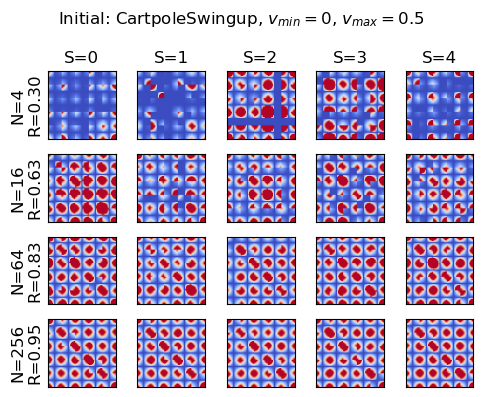

In [6]:
scaling = 0 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 0.5
l = 0
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print("Seed Correlation across widths:", feat_sim)


Seed Correlation across widths: [0.12657742 0.16698457 0.05449972 0.16375167]


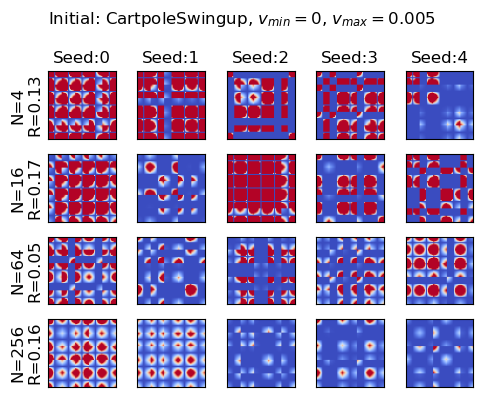

In [7]:
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 0.005
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")
l = 0

logit_sim = np.zeros(len(N_to_plot))
A = []
Ax = []
for N in N_to_plot:
    n =  N_keys_corresponding_idxs[N]

    storex = []
    store= []
    for s in range(5):
        x =  logits_loaded[scaling, n, s]
        k = x@x.T # don't normalize by N
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        store.append(x)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    logit_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[l, 0].set_ylabel(f"N={N}\nR={logit_sim[l]:.2f}", fontsize=12)
    A.append(storex)
    Ax.append(store)
    
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/logit_seed_{name}_{env_name}.pdf",bbox_inches='tight')
print("Seed Correlation across widths:", logit_sim)

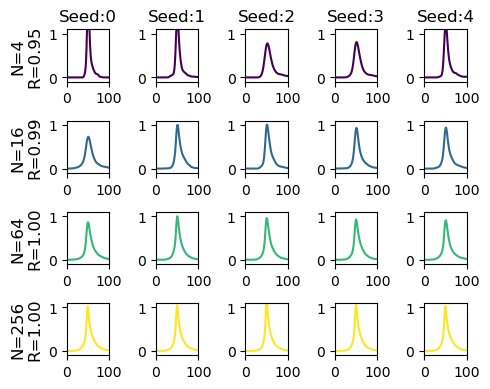

In [8]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Analyze NTK features

Key: 4, Value: (3, 5, 65, 4)
Key: 16, Value: (3, 5, 65, 16)
Key: 64, Value: (3, 5, 65, 64)
Key: 256, Value: (3, 5, 65, 256)
[0.13221864 0.51174054 0.72673296 0.76833899]


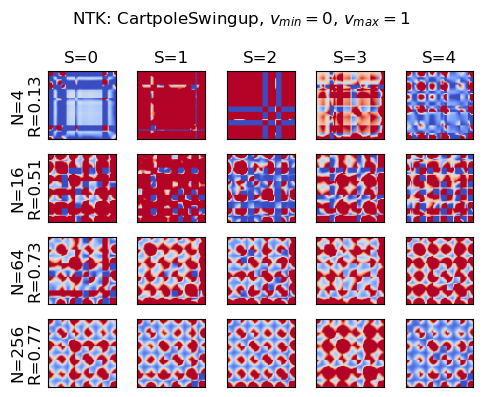

In [9]:
scaling = 1 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 1
l = 0
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print(feat_sim)


[0.01122177 0.1556097  0.14629798 0.17588238]


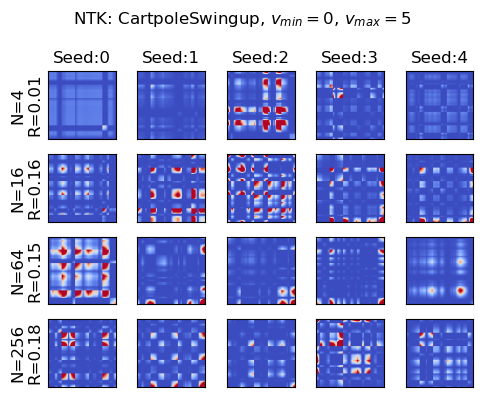

In [10]:
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 5
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")
l = 0

logit_sim = np.zeros(len(N_to_plot))
A = []
Ax = []
for N in N_to_plot:
    n =  N_keys_corresponding_idxs[N]

    storex = []
    store= []
    for s in range(5):
        x =  logits_loaded[scaling, n, s]
        k = x@x.T # don't normalize by N
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        store.append(x)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    logit_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[l, 0].set_ylabel(f"N={N}\nR={logit_sim[l]:.2f}", fontsize=12)
    A.append(storex)
    Ax.append(store)
    
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/logit_seed_{name}_{env_name}.pdf",bbox_inches='tight')
print(logit_sim)

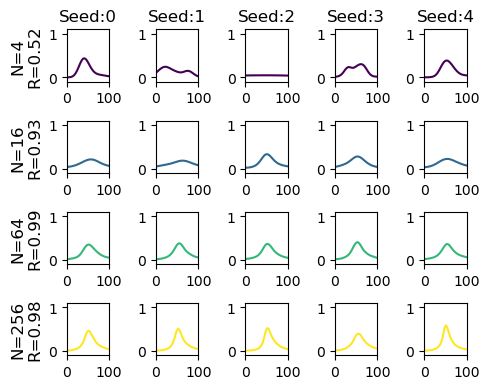

In [11]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Analyze muP Features

Key: 4, Value: (3, 5, 65, 4)
Key: 16, Value: (3, 5, 65, 16)
Key: 64, Value: (3, 5, 65, 64)
Key: 256, Value: (3, 5, 65, 256)
[0.16662544 0.67844594 0.7976295  0.78961876]


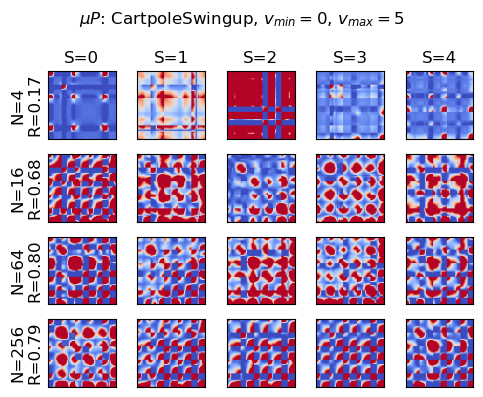

In [12]:
scaling = 2 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 5
l = 0
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print(feat_sim)


[0.03681165 0.15222711 0.09833524 0.19721055]


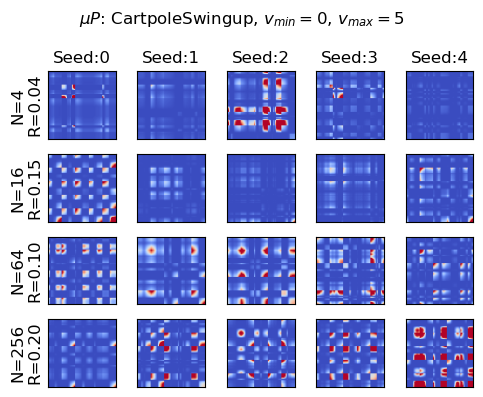

In [13]:
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 5
f.suptitle(f"{name}: {env_name}, $v_{{min}}=0$, $v_{{max}}={vmax}$")
l = 0

logit_sim = np.zeros(len(N_to_plot))
A = []
Ax = []
for N in N_to_plot:
    n =  N_keys_corresponding_idxs[N]

    storex = []
    store= []
    for s in range(5):
        x =  logits_loaded[scaling, n, s]
        k = x@x.T # don't normalize by N
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        store.append(x)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    logit_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[l, 0].set_ylabel(f"N={N}\nR={logit_sim[l]:.2f}", fontsize=12)
    A.append(storex)
    Ax.append(store)
    
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/logit_seed_{name}_{env_name}.pdf",bbox_inches='tight')
print(logit_sim)

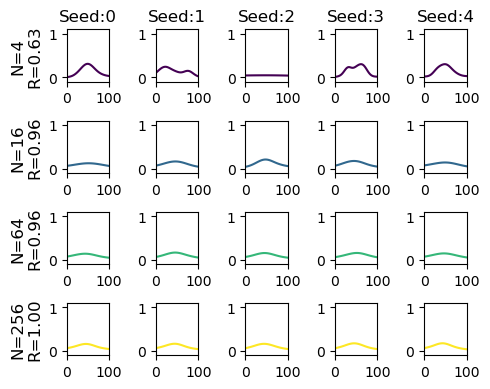

In [14]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Plot all 3 together

64 2
256 0
1024 1
64 2
256 0
1024 1
64 2
256 0
1024 1


/tmp/ipykernel_1919859/3566148369.py:83: UserWarning: The figure layout has changed to tight
  f.tight_layout()


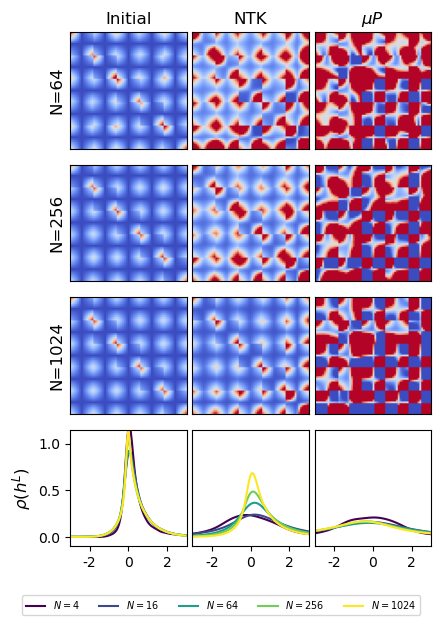

In [76]:
from matplotlib.lines import Line2D

# get individual colors from viridis

N_to_plot = [64, 256, 1024]
num_models = hdensity_loaded.shape[1]
colors = [cmap(i / (num_models-1)) for i in range(num_models)]
feat_sim = np.zeros(3)

f,ax = plt.subplots(len(N_to_plot)+1, 3, figsize=(1.5*3, 1.5*(len(N_to_plot)+1)),  constrained_layout=True)

for scaling in range(3):
    storeh = []

    if scaling == 0:
        vmax = .5
    elif scaling == 1:
        vmax = 0.5
    else:
        vmax = 5
    vmax = 2

    for key, feat in feature_layers_dict_loaded.items():
        if key not in N_to_plot:
            continue
        
        n =  N_keys_corresponding_idxs[key]

        print(key, i)

        i = N_to_plot.index(key)

        X = feat[scaling]
        K = np.einsum('ijk,ilk->ijl', X, X) / key

        K_mean = np.nanmean(K,axis=0)

        ax[i,scaling].imshow(K_mean, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)

        storeh.append(h.reshape(1,-1))
        ax[i,scaling].set_xticks([])
        ax[i,scaling].set_yticks([])
        ax[i, 0].set_ylabel(f"N={key}", fontsize=12)

        # h = np.nanmean(hdensity_loaded[scaling, n],axis=0)
        # ax[-1,scaling].plot(h)
        # ax[-1,0].set_ylabel(f"$\\rho(h^L)$", fontsize=12)           
   
    ax[0,scaling].set_title(name_list[scaling],fontsize=12)
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    feat_sim[scaling] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


for scaling in range(3):

    for n in range(num_models):

        h = np.nanmean(hdensity_loaded[scaling, n],axis=0)
        if np.sum(h) == 0:
            continue
        N = list(N_keys_corresponding_idxs.keys())[n]

        ax[-1,scaling].plot(h, color=colors[n], label=f'$N={N}$')
        ax[-1,scaling].set_xlim([0, h.shape[0]])
        ax[-1,scaling].set_ylim([-0.1, 1.15])
        # # Plot a box around the MAE region
        # ax[-1,scaling].axvspan(timestep_idx-1, timestep_idx+1, color='red', alpha=0.2)
        # ax[-1,scaling].set_aspect('equal')
        ax[-1,scaling].set_box_aspect(1)  # Only in matplotlib >= 3.4
        # ax[-1,scaling].set_xticks([])  # Hide x-axis ticks for top row
        if scaling != 0:
            ax[-1,scaling].set_yticks([])
        ax[-1,scaling].set_xticks(np.linspace(0,100,7)[1::2], np.linspace(-3,3,7,dtype=int)[1::2])

    ax[-1,0].set_ylabel(f"$\\rho(h^L)$", fontsize=12)         
    # Add legend box at the bottom of the figure

    if scaling == 0:
        f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=num_models, fontsize=7, frameon=True)


f.tight_layout()
f.subplots_adjust(wspace=0.05, hspace=0.05)
f.savefig(f"{fig_dir}/kernels_density_{env_name}.pdf",bbox_inches='tight')

### CKA within seeds and across width

In [88]:
from scipy.spatial import procrustes
from numpy.linalg import norm

def centered_kernel_alignment(X, Y):
    """
    Computes centered kernel alignment between two matrices.
    Both matrices are expected to be of shape (n_samples, n_features).
    """
    def center_kernel(K):
        n = K.shape[0]
        H = np.eye(n) - np.ones((n, n))/n
        return H @ K @ H
    
    Kx = X @ X.T
    Ky = Y @ Y.T
    Kx_c = center_kernel(Kx)
    Ky_c = center_kernel(Ky)
    numerator = np.sum(Kx_c * Ky_c)
    denominator = np.sqrt(np.sum(Kx_c ** 2) * np.sum(Ky_c ** 2))
    return numerator / denominator

def procrustes_alignment(X, Y):
    """
    Performs Procrustes analysis and returns the similarity.
    Matrices should be of the same shape (n_samples, n_features).
    """
    # scipy's procrustes aligns the shapes, returning mtx1, mtx2, disparity
    _, _, disparity = procrustes(X, Y)
    # Similarity can be defined as 1 - disparity (lower disparity = higher similarity)
    return 1 - disparity

def cosine_similarity_matrix(A, B):
    """
    Computes cosine similarity between two matrices (flattened).
    """
    a_flat = A.flatten()
    b_flat = B.flatten()
    return np.dot(a_flat, b_flat) / (norm(a_flat) * norm(b_flat))

In [101]:
# CKA analysis within seeds and across width
across_width = np.zeros((3, len(layer_sizes), len(layer_sizes)))
within_seed = np.zeros((3,len(layer_sizes), num_seeds, num_seeds))

for scaling in range(3):

    Ks = np.zeros([len(layer_sizes), feat.shape[2], feat.shape[2]])

    for N, feat in feature_layers_dict_loaded.items():
        if np.sum(feat) == 0:
            continue
        H = feat[scaling]
        K = np.einsum('ijk,imn->ijm', H, H) / N # shape (num_seeds, num_points, num_points)

        n = layer_sizes.index(N)
        Ks[n] = np.nanmean(K, axis=0)
        
        for i in range(num_seeds):
            for j in range(num_seeds):
                within_seed[scaling, n, i, j] = centered_kernel_alignment(K[i], K[j])

    for i, N2 in enumerate(layer_sizes):
        for j, N3 in enumerate(layer_sizes):
            across_width[scaling, i, j] = centered_kernel_alignment(Ks[i], Ks[j])
    


In [105]:
# get the mean of the lower triangular value of the matrix
within_seed_mean = np.zeros((3, len(layer_sizes)))
for scaling in range(3):
    for n in range(len(layer_sizes)):
        tri_vals = within_seed[scaling, n]
        within_seed_mean[scaling, n] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()

across_width_mean = np.zeros(3)
for scaling in range(3):
    tri_vals = across_width[scaling]
    across_width_mean[scaling] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
print("Across width CKA mean:", across_width_mean)

Across width CKA mean: [0.82252245 0.44950102 0.44278546]


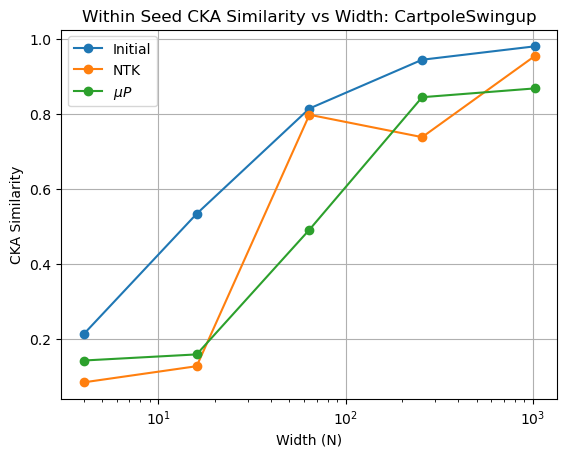

In [106]:
plt.figure()
for scaling in range(3):
    plt.plot(layer_sizes, within_seed_mean[scaling], label=name_list[scaling], marker='o')
plt.xscale('log')
plt.xlabel('Width (N)')
plt.ylabel('CKA Similarity')
plt.title(f'Within Seed CKA Similarity vs Width: {env_name}')
plt.legend()
plt.grid(True)
